In [1]:
import numpy as np
from skimage.io import imread
import time
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage
from skimage import io as skio
import IPython
from skimage.transform import rescale
from skimage.io import imread
from scipy.spatial import distance
import sys
from scipy.fft import dct, idct, dctn, idctn

In [8]:
#================================== Parameters initialization ==================================

sigma = 25 # variance of the noise

lamb2d = 2.0

lamb3d = 2.7

Step1_ThreDist = 250 # threshold distance

Step1_MaxMatch = 16 # max matched blocks

Step1_BlockSize = 8

Step1_spdup_factor = 3 # pixel jump for new reference block

Step1_WindowSize = 39 # search window size  

In [3]:
def noisegauss(im,br=sigma):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def viewimage(im, normalize=True,z=1,order=0,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255 
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

In [22]:
# Step 1

def distpatch(patch1, patch2, khard=8):
    """
    Calcul distance entre deux patchs (sans seuillage).

    patch1, patch2: 1D arrays (flatten)
    """
    if patch1.size != patch2.size:
        print('Error: two patches should be in same size in function distpatch().\n')
        sys.exit()

    p1 = patch1.astype(np.float32)
    p2 = patch2.astype(np.float32)

    diff = p1 - p2
    dist = np.sqrt(np.sum(diff * diff)) / (khard ** 2)  # Normalization
    return dist

def grouping(noisy,
             center_i=None, center_j=None,
             patch_size=Step1_BlockSize, 
             search_window=Step1_WindowSize,
             max_similar_patches=Step1_MaxMatch, 
             threshard=Step1_ThreDist):
    """
    Find and group patches from the image *im*, return a 3D array of patches.

    Note that the distance computing is chosen from original paper rather than the analysis one.

    - noisy: 2D noised image
    - (center_i, center_j): Center of reference patch. If center = None, the center of the image will be used
    - patch_size: Size of patch (default = 8)
    - search_window: Size of the search window (in pixels)
    - max_similar_patches: Nhard
    - threshard: Distance threshold for accepting a patch
    """
    H, W = noisy.shape
    half_p = patch_size // 2
    half_w = search_window // 2

    # Select the center of the reference patch.
    if center_i is None:
        center_i = H // 2
    if center_j is None:
        center_j = W // 2
    center_i = np.clip(center_i, half_p, H - half_p - 1)
    center_j = np.clip(center_j, half_p, W - half_p - 1)

    # build the reference patch.
    ref_patch = noisy[center_i - half_p:center_i + half_p,
                   center_j - half_p:center_j + half_p]

    # Range of search window.
    i_min = max(center_i - half_w, half_p)
    i_max = min(center_i + half_w, H - half_p)
    j_min = max(center_j - half_w, half_p)
    j_max = min(center_j + half_w, W - half_p)

    similar_patches = []

    # Patch center.
    for i in range(i_min, i_max):
        for j in range(j_min, j_max):
            current_patch = noisy[i - half_p:i + half_p,
                               j - half_p:j + half_p]
            dist = distpatch(ref_patch.flatten(),
                             current_patch.flatten(),
                             khard=patch_size)
            if dist < threshard:
                similar_patches.append((dist, current_patch.copy()))

    # Use *ref_patch* if no similar patches are found.
    if len(similar_patches) == 0:
        similar_patches.append((0.0, ref_patch.copy()))

    # Sorting, then keep the smallest *max_similar_patches* patches.
    similar_patches.sort(key=lambda x: x[0])
    selected = [p for (d, p) in similar_patches[:max_similar_patches]]

    # 3D block: (patch_size, patch_size, nb_patches)
    block_3D = np.stack(selected, axis=2)

    return block_3D, (center_i, center_j)


def hard_threshold(coeffs, l=lamb2d, sigma =sigma):
    thresh = l * sigma
    coeffs = coeffs.copy()
    coeffs[np.abs(coeffs) < thresh] = 0
    return coeffs

def ondelet_3D(block_3D):
    '''
    Transfo ondelettes 3D sur un block 3D de patchs.
    '''
    # 3D DCT
    block_3D = np.asarray(block_3D, dtype=np.float32)
    coeffs = dctn(block_3D, axes=(0, 1, 2), type=2, norm='ortho')
    return coeffs

def invondelet_3D(coeffs):
    coeffs = np.asarray(coeffs, dtype=np.float32)
    block_rec = idctn(coeffs, axes=(0, 1, 2), type=2, norm='ortho')
    return block_rec

def collaborative_filtering(block_3D, lam, sigma_noise):
    D = ondelet_3D(block_3D)
    D_thr = hard_threshold(D, lam, sigma_noise)
    block_filtered = invondelet_3D(D_thr)
    return block_filtered

def imread_gray(path):
    im = imread(path)
    if im.ndim == 3:
        im = np.mean(im, axis=2)    
    return im.astype(np.float32)

In [27]:
def aggregation(
    v,
    w,
    block_filtered,
    coords,
    patch_size,
    weight=1.0
):
    half_p = patch_size // 2
    H, W = v.shape
    num_patches = block_filtered.shape[2]

    for n in range(num_patches):
        pi, pj = coords[n]
        top = pi - half_p
        left = pj - half_p
        bottom = top + patch_size
        right  = left + patch_size

        # Protection around boundaries..
        if top < 0 or left < 0 or bottom > H or right > W:
            continue

        patch = block_filtered[:, :, n]

        v[top:bottom, left:right] += weight * patch
        w[top:bottom, left:right] += weight

In [ ]:
def bm3d_step1(noisy,
               patch_size=8,
               search_window=16,
               max_similar_patches=16,
               step=3,
               lam=2.7,
               sigma_noise=20.0):

    noisy = noisy.astype(np.float32)
    H, W = noisy.shape
    half_p = patch_size // 2

    v = np.zeros_like(noisy, dtype=np.float32)  # Pixels
    w = np.zeros_like(noisy, dtype=np.float32)  # Weights

    # for each center of patches:
    for i in range(half_p, H - half_p, step):
        for j in range(half_p, W - half_p, step):
            # grouping
            block_3D, coords = grouping(
                noisy,
                center_i=i,
                center_j=j,
                patch_size=patch_size,
                search_window=search_window,
                max_similar_patches=max_similar_patches,
                threshard=250.0  
            )
            # collaborative filtering
            block_filtered = collaborative_filtering(block_3D, lam, sigma_noise)

            # (patch_size, patch_size, N)
            aggregation(
                v, w,
                block_filtered,
                coords,
                patch_size=patch_size,
                weight=1.0  
            )
    eps = 1e-8
    u_hat = v / (w + eps)

    # If weight = 0, then use *noisy*.
    mask_zero = (w < eps)
    u_hat[mask_zero] = noisy[mask_zero]

    return u_hat


In [11]:
im = imread_gray('img/pyramide.tif')


In [12]:
# Test:
coeffs = np.array([-5, -1, 0, 2, 10], dtype=np.float32)
l = 1.5
noise = 2.0
# threshould = l * noise = 3
out = hard_threshold(coeffs, l, noise)
print("[test_hard_threshold]")
print("input :", coeffs)
print("output:", out)


[test_hard_threshold]
input : [-5. -1.  0.  2. 10.]
output: [-5.  0.  0.  0. 10.]


In [13]:
patch_size = 8
nb_patches = 4
block = np.random.randn(patch_size, patch_size, nb_patches).astype(np.float32)
coeffs = ondelet_3D(block)
recon  = invondelet_3D(coeffs)
err = np.max(np.abs(block - recon))
print("[test_transform_inverse] max abs error =", err)


[test_transform_inverse] max abs error = 8.34465e-07


[test_one_block_denoising] block_3D shape: (8, 8, 16)


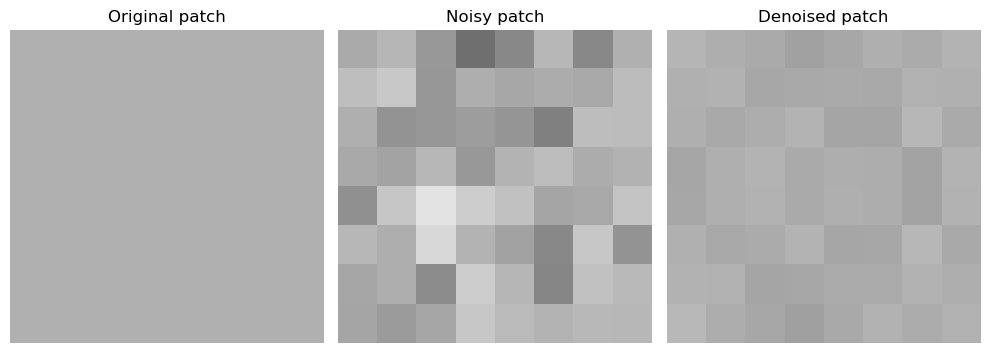

In [14]:
img_n = noisegauss(im, sigma)

block_3D, (ci, cj) = grouping(
        img_n,
        patch_size=patch_size,
        search_window=Step1_WindowSize,
        max_similar_patches=Step1_MaxMatch,
        threshard=Step1_ThreDist
    )
print("[test_one_block_denoising] block_3D shape:", block_3D.shape)

l = 2.5
# Good if the result is (8, 8, N).
block_filtered = collaborative_filtering(block_3D, l, sigma)

noisy_patch = block_3D[:, :, 0]
denoised_patch = block_filtered[:, :, 0]

half = patch_size // 2
clean_patch = im[ci-half:ci+half, cj-half:cj+half]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(clean_patch, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original patch")
axes[0].axis('off')

axes[1].imshow(noisy_patch, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Noisy patch")
axes[1].axis('off')

axes[2].imshow(denoised_patch, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Denoised patch")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Step 2

def grouping_2(
    basic,                 # DIFFERENCE FROM STEP1: We need to input basic estimate as well.
    noisy,                 
    center_i=None, vcenter_j=None,
    patch_size=8,
    search_window=16,
    max_similar_patches=16,
    threshard=250.0
):
    H, W = basic.shape
    half_p = patch_size // 2
    half_w = search_window // 2

    if center_i is None:
        center_i = H // 2
    if center_j is None:
        center_j = W // 2

    center_i = np.clip(center_i, half_p, H - half_p - 1)
    center_j = np.clip(center_j, half_p, W - half_p - 1)

    # <<< DIFFERENCE FROM STEP1: parameter *ref_patch* comes from *basic*.
    ref_patch_basic = basic[center_i - half_p:center_i + half_p,
                            center_j - half_p:center_j + half_p]
    # in case...
    ref_patch_noisy = noisy[center_i - half_p:center_i + half_p,
                            center_j - half_p:center_j + half_p]

    i_min = max(center_i - half_w, half_p)
    i_max = min(center_i + half_w, H - half_p)
    j_min = max(center_j - half_w, half_p)
    j_max = min(center_j + half_w, W - half_p)

    similar = []   # DIFFERENCE FROM STEP1: (dist, basic_patch, noisy_patch, (i,j))

    # For each patch...
    for i in range(i_min, i_max):
        for j in range(j_min, j_max):
            patch_basic = basic[i - half_p:i + half_p,
                                j - half_p:j + half_p]

            dist = distpatch(ref_patch_basic.flatten(),
                             patch_basic.flatten(),
                             khard=patch_size)

            if dist < threshard:
                patch_noisy = noisy[i - half_p:i + half_p,
                                    j - half_p:j + half_p]
                similar.append((
                    dist,
                    patch_basic.copy(),
                    patch_noisy.copy(),
                    (i, j)
                ))

    if len(similar) == 0:
        similar = [(
            0.0,
            ref_patch_basic.copy(),
            ref_patch_noisy.copy(),
            (center_i, center_j)
        )]

    similar.sort(key=lambda x: x[0])
    selected = similar[:max_similar_patches]

    basic_patches = [p_b for (d, p_b, p_n, coord) in selected]
    noisy_patches = [p_n for (d, p_b, p_n, coord) in selected]
    coords        = [coord for (d, p_b, p_n, coord) in selected]

    # Build 2 sets of 3D blocks.
    basic_block_3D = np.stack(basic_patches, axis=2)
    noisy_block_3D = np.stack(noisy_patches, axis=2)

    return basic_block_3D, noisy_block_3D, coords

In [ ]:
def wiener(Tn, 
           Tb_energy, 
           sigma_noise, 
           eps=1e-8):
    noise_var = sigma_noise * sigma_noise
    G = Tb_energy / (Tb_energy + noise_var + eps)
    Tn_filtered = G * Tn

    return Tn_filtered, G

In [25]:
def collaborative_filtering_2(
    basic_block_3D,
    noisy_block_3D,
    sigma_noise,
    wiener_eps=1e-8,
):
    basic_block_3D = np.asarray(basic_block_3D, dtype=np.float32)
    noisy_block_3D = np.asarray(noisy_block_3D, dtype=np.float32)

    Tb = ondelet_3D(basic_block_3D)
    Tn = ondelet_3D(noisy_block_3D)

    Tb_energy = np.mean(Tb * Tb, axis=2, keepdims=True)

    Tn_filtered, G = wiener(Tn, Tb_energy, sigma_noise, eps=wiener_eps)

    block_filtered = invondelet_3D(Tn_filtered)

    weight = 1.0 / (np.sum(G * G) + wiener_eps)

    return block_filtered, weight


In [ ]:
def aggregation_2(
    v2,
    w2,
    block_filtered,
    coords,
    patch_size,
    weight
):
    half_p = patch_size // 2
    H, W = v2.shape

    num_patches = block_filtered.shape[2]

    for n in range(num_patches):
        pi, pj = coords[n]
        top  = pi - half_p
        left = pj - half_p
        bottom = top + patch_size
        right  = left + patch_size

        # Protection around boundaries.
        if top < 0 or left < 0 or bottom > H or right > W:
            continue

        patch = block_filtered[:, :, n]

        v2[top:bottom, left:right] += weight * patch
        w2[top:bottom, left:right] += weight

In [ ]:
def bm3d_step2(
    noisy,
    basic,
    patch_size=8,
    search_window=16,
    max_similar_patches=16,
    step=3,
    sigma_noise=20.0,
    wiener_eps=1e-8
):
    noisy = noisy.astype(np.float32)
    basic = basic.astype(np.float32)

    H, W = noisy.shape
    half_p = patch_size // 2

    v2 = np.zeros_like(noisy, dtype=np.float32)
    w2 = np.zeros_like(noisy, dtype=np.float32)

    # For each center of patches (same as step 1):
    for i in range(half_p, H - half_p, step):
        for j in range(half_p, W - half_p, step):
            basic_block_3D, noisy_block_3D, coords = grouping_2(
                basic,
                noisy,
                center_i=i,
                center_j=j,
                patch_size=patch_size,
                search_window=search_window,
                max_similar_patches=max_similar_patches,
                threshard=250.0 
            )

            block_filtered, weight = collaborative_filtering_2(
                basic_block_3D,
                noisy_block_3D,
                sigma_noise=sigma_noise,
                wiener_eps=wiener_eps
            )

            aggregation_2(
                v2,
                w2,
                block_filtered,
                coords,
                patch_size,
                weight
            )

    eps = 1e-8
    final_estimate = np.empty_like(noisy, dtype=np.float32)

    mask = w2 > eps
    final_estimate[mask] = v2[mask] / w2[mask]
    final_estimate[~mask] = noisy[~mask]   # Use *noisy* to fill the uncovered areas.

    return final_estimate
